<a href="https://colab.research.google.com/github/Junoquu/Solar-Sunspot-Prediction-Using-LSTM/blob/main/LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%ED%83%9C%EC%96%91_%ED%9D%91%EC%A0%90_%EC%88%98_%EC%98%88%EC%B8%A1(2017108071_%EB%B6%80%EC%A4%80%ED%98%B8)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 개요 및 필요성

### 흑점 변화가 왜 중요한가?
> 태양 활동이 활발해질수록 지구에 당도하는 태양 에너지 입자가 증가해 통신과 전력망, 항공기 운항 시스템, 우주선 등 매우 중요한 시스템들의 장애를 일으킬 수 있기 때문이다.

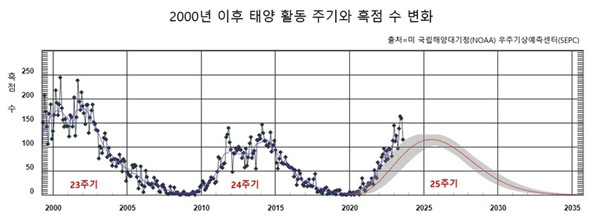

(현재 태양은 25주기를 지나고 있다.)

# 2. 데이터 설명
브뤼셀의 벨기에 왕립천문대(SILSO)에서 제공한 1850년 부터 2023년 8월 31일 까지의 일일 흑점 데이터이다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from math import sqrt
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

df_filepath = ('/content/drive/MyDrive/Colab Notebooks/daily_sunspots_time_series_1850_2023.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CSV 파일을 불러오기
data = pd.read_csv(df_filepath)

In [ ]:
data

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN
...,...,...,...,...,...,...,...,...,...
63425,2023-08-27,2023,8,27,2023.653,84,10.5,31,*
63426,2023-08-28,2023,8,28,2023.656,84,12.3,36,*
63427,2023-08-29,2023,8,29,2023.659,88,11.8,28,*
63428,2023-08-30,2023,8,30,2023.662,104,14.8,32,*


# 3. 데이터 분석 및 전처리

In [ ]:
# 데이터 프레임 타입 분석
data.dtypes

date          object
year           int64
month          int64
day            int64
date_frac    float64
counts         int64
std          float64
nobs           int64
indicator     object
dtype: object

In [ ]:
# 결측치 확인
data.isnull().sum()

date             0
year             0
month            0
day              0
date_frac        0
counts           0
std              0
nobs             0
indicator    63277
dtype: int64

In [ ]:
# 결측치 제거
data=data.drop(columns=['indicator'])

In [ ]:
data

,date,year,month,day,date_frac,counts,std,nobs
0,1850-01-01,1850,1,1,1850.001,253,19.6,1
1,1850-01-02,1850,1,2,1850.004,162,15.5,1
2,1850-01-03,1850,1,3,1850.007,217,18.1,1
3,1850-01-04,1850,1,4,1850.010,99,12.0,1
4,1850-01-05,1850,1,5,1850.012,108,12.6,1
...,...,...,...,...,...,...,...,...
63425,2023-08-27,2023,8,27,2023.653,84,10.5,31
63426,2023-08-28,2023,8,28,2023.656,84,12.3,36
63427,2023-08-29,2023,8,29,2023.659,88,11.8,28
63428,2023-08-30,2023,8,30,2023.662,104,14.8,32


# 4. 데이터 시각화

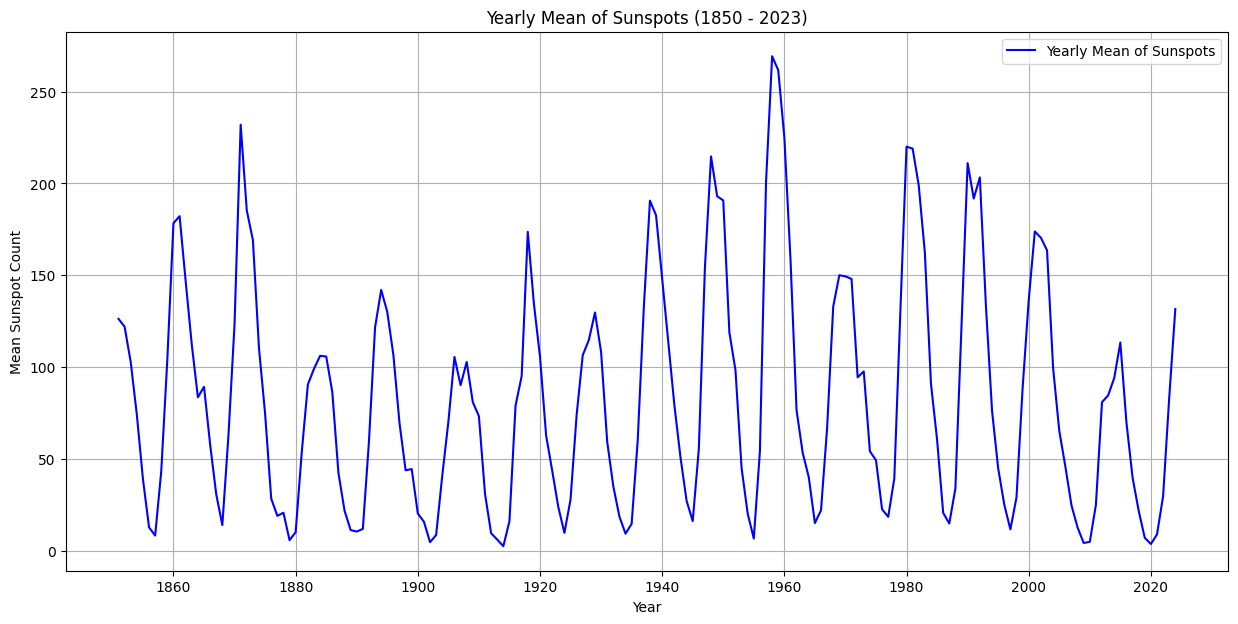

In [ ]:
# 'data'의 데이터 시간 형식으로 변환하고 인덱스로 설정
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 태양 흑점 수의 연도별 평균을 계산
yearly_sunspots = data['counts'].resample('Y').mean()

# 시각화
plt.figure(figsize=(15, 7))
plt.plot(yearly_sunspots, label='Yearly Mean of Sunspots', color='blue')
plt.title('Yearly Mean of Sunspots (1850 - 2023)')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Count')
plt.legend()
plt.grid(True)
plt.show()

# 데이터 분할

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['counts'].values.reshape(-1,1))

In [ ]:
# 시퀀스 생성 함수
def create_dataset(dataset, look_back=63430):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# 시퀀스 생성
look_back = 30  # 시퀀스 길이
X, y = create_dataset(data_scaled, look_back)

In [ ]:
# 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 학습을 위한 LSTM 모델 구축

In [ ]:
# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
793/793 [==============================] - 12s 11ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 2/20
793/793 [==============================] - 7s 8ms/step - loss: 0.0021 - val_loss: 8.5782e-04
Epoch 3/20
793/793 [==============================] - 7s 9ms/step - loss: 0.0020 - val_loss: 8.6799e-04
Epoch 4/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0019 - val_loss: 8.1068e-04
Epoch 5/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0019 - val_loss: 8.0147e-04
Epoch 6/20
793/793 [==============================] - 7s 8ms/step - loss: 0.0019 - val_loss: 8.4462e-04
Epoch 7/20
793/793 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 8.4365e-04
Epoch 8/20
793/793 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 7.7777e-04
Epoch 9/20
793/793 [==============================] - 6s 8ms/step - loss: 0.0019 - val_loss: 8.2156e-04
Epoch 10/20
793/793 [==============================] - 8s 11ms/s

# 학습 결과 및 성능 평가

회귀 문제에서는 정확도(accuracy)가 일반적으로 사용되지 않는 평가 지표이므로, 회귀 성능을 측정하기 위해 RMSE, MAE, R²사용할 것이다.
> **1. 평균 제곱근 오차 (Root Mean Squared Error, RMSE)** : 모델의 예측 값과 실제 값 간의 차이의 제곱근으로 RMSE 값이 낮을수록 모델의 예측 정확도가 높다고 할 수 있다.  
> **2. 평균 절대 오차 (Mean Absolute Error, MAE)** : 모델의 예측 값과 실제 값 간의 절대 차이의 평균으로 MAE 값은 예측 값의 오차가 얼마나 큰지를 직관적으로 이해하는 데 도움이 된다.  
> **3. R² (결정 계수)**: 모델이 데이터의 변동성을 얼마나 잘 설명하는지 나타내는 지표로 이 값이 1에 가까울수록 모델이 데이터를 잘 설명한다고 볼 수 있다.  

In [ ]:
# 모델 성능 평가
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

397/397 [==============================] - 2s 4ms/step - loss: 7.8602e-04
Test Loss: 0.0007860152400098741


In [ ]:
# 테스트 데이터셋에 대한 예측 수행
y_pred = model.predict(X_test)

397/397 [==============================] - 2s 3ms/step


In [ ]:
# 예측값 역변환 (정규화된 값을 원래 스케일로 변환)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# RMSE 계산
rmse = sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAE 계산
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Error (MAE): {mae}")

# R² 계산
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 14.802990514652835
Mean Absolute Error (MAE): 10.709869230113195
R-squared (R²): 0.9592203918095094


**Root Mean Squared Error (RMSE): 14.707762429508458 -- 약 14.71**  
> 여기서 RMSE 값은 약 14.71으로, 이는 모델이 평균적으로 각 예측에서 약 14.71의 오차를 가진다는 것을 의미한다.  

**Mean Absolute Error (MAE): 10.726453515671029 -- 약 10.73**
> MAE 값이 약 10.73 이므로, 평균적으로 모델의 예측이 실제 값과 약 10.73만큼 차이가 난다는 것을 의미한다.  

**R-squared (R²): 0.9597433770938847 -- 약 0.96**
> R² 값이 약 0.96이므로, 모델이 데이터의 대부분의 변동성을 잘 설명하고 있다고 볼 수 있다.

## 30일 후 태양 흑점 수 예측하기

In [ ]:
# 예측 결과 출력
y_pred_inverse[:365].flatten()

array([187.71677 , 215.62308 , 230.65025 , 257.8224  , 271.62704 ,
       270.74554 , 272.64124 , 261.23935 , 258.44858 , 252.96591 ,
       244.59549 , 293.36652 , 281.85718 , 239.39491 , 217.89099 ,
       208.20554 , 209.63936 , 235.54953 , 238.35156 , 221.47842 ,
       213.47293 , 189.15488 , 214.785   , 190.35812 , 158.46486 ,
       197.63504 , 190.64737 , 214.95341 , 208.51407 , 216.96994 ,
       246.29    , 272.00314 , 291.87366 , 266.7146  , 240.63121 ,
       223.52855 , 206.89217 , 195.36784 , 200.48325 , 181.70207 ,
       164.98785 , 151.85863 , 207.98778 , 223.76392 , 189.6795  ,
       185.86588 , 194.07274 , 200.18643 , 216.78242 , 215.76184 ,
       202.21848 , 181.42545 , 175.87277 , 179.95511 , 202.72282 ,
       173.88385 , 162.92174 , 162.5408  , 167.54453 , 199.5465  ,
       214.76505 , 236.27516 , 234.90509 , 258.84363 , 264.54684 ,
       250.2286  , 228.42734 , 229.67987 , 245.22823 , 200.88643 ,
       194.72957 , 203.18741 , 183.66641 , 174.8594  , 166.345

In [ ]:
# 미래 날짜 생성
data = pd.read_csv(df_filepath)
last_date = pd.to_datetime(data['date'].iloc[-1])
future_dates = pd.date_range(start=last_date, periods=365 + 1, closed='right')

<ipython-input-44-3ab9660c852a>:4: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_date, periods=365 + 1, closed='right')


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

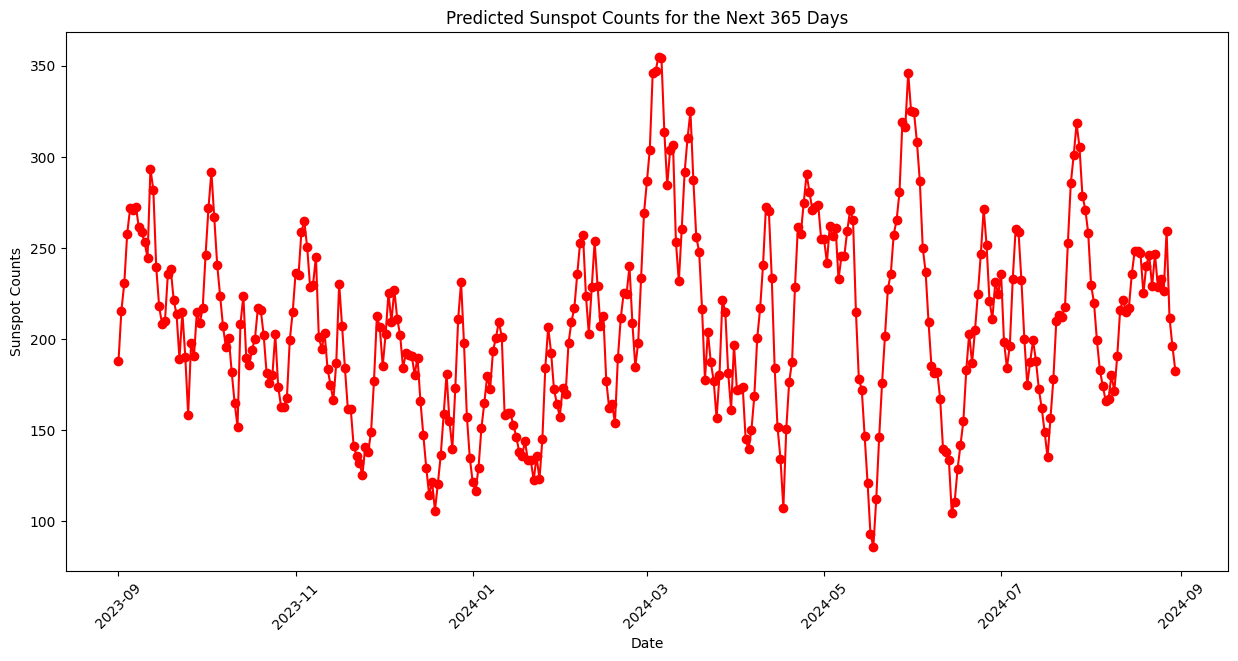

In [ ]:
# 미래 예측값 시각화
plt.figure(figsize=(15, 7))
plt.plot(future_dates, y_pred_inverse[:365], label='Predicted Future Sunspot Counts', color='red', marker='o')
plt.xticks(rotation=45)
plt.title('Predicted Sunspot Counts for the Next 365 Days')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')
plt

# 결론
태양 흑점은 주기마다 그 수가 늘어 지구에 영향을 많이 끼치는데 본 연구에서 진행한 예측 방안을 토대로 태양 흑점 수가 많아지는 시기를 특정할 수 있어 태양풍 때문인 피해를 최소화할 수 있을 것으로 예상된다.